<a href="https://colab.research.google.com/github/ioanabuze/DE_Group_Project_2020/blob/master/Amazon_Review_Weak_Labelling_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction

The scope of this project is to use Snorkel DryBell generative approach to produce a set of weak labels for a chosen dataset.

The proposed dataset consists of Amazon Consumer Reviews of Amazon Products. The aim is to train a classifier over the review data that can predict whether reviews are positive, negative or neutral. We have access to both the review text and the review rating for the project. The rating will be removed and kept aside as gold labels so that we can check the accuracy of our work. For training a classifier, we will label the data. However, hand-labelling tens of thousand of data points is generally slow and costly. Therefore, we will use a weak supervision approach using labelling functions in Snorkel. This are noisy, programmatically rules and heuristics that appoint labels to unlabeled training data (Snorkel.org, 2020).

The reviews dataset contains a ratings column for each Amazon product. The rating column rates products from 1 (really bad) to 5 (very good). As such, two labelling funtions will be created to determine whether positive reviews are contained in the last 2 rating tiers, negative reviews are contained in the first two rating tiers and neutral reviews are contained in the third rating tier. The most common positive, negative and netural words that were identified in the dataset will be used to determine the type of review. These labels will be then used as a basis Descriminative model, will be trained to further enhance the model performance and will further be used to evaluate the accuracy of the combination of the models.

## 2. Installing Libraries and Setup

We will start by installing and importing all the necessary libraries.

In [0]:
!pip install snorkel

     |████████████████████████████████| 143kB 3.5MB/s 
     |████████████████████████████████| 194kB 48.5MB/s 
     |████████████████████████████████| 676.9MB 23kB/s 
     |████████████████████████████████| 6.7MB 42.5MB/s 
     |████████████████████████████████| 1.8MB 51.8MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=e6653106d944aa1c1e5cdf24ae28322e79e94bc22203becfa3d0d71f1d6200dd
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: sc

In [0]:
import nltk
nltk.download("popular")
nltk.download('vader_lexicon')
nltk.download('brown')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [0]:
 # pyspark setup

!pip install pyspark
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive")

     |████████████████████████████████| 217.8MB 64kB/s 
     |████████████████████████████████| 204kB 46.2MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=199d4e47394f26f1f3ac897412bf68fffa0d9add2399c6a4aba44bfbe9bae373
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Setup the correct path
cd "/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project"

/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project


In [0]:
from snorkel.labeling.apply.spark import SparkLFApplier
from snorkel.labeling import MajorityLabelVoter
from snorkel.labeling import labeling_function, LFAnalysis, LabelModel, PandasLFApplier
from snorkel.preprocess import preprocessor
from snorkel.labeling import filter_unlabeled_dataframe
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

import nltk
import re
import string
import spacy

from functools import reduce
from wordcloud import WordCloud
from textblob import TextBlob 
import pyspark.sql.functions as f
from textblob import TextBlob

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

from snorkel.utils import probs_to_preds

In [0]:
import os 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

COLAB_NOTEBOOKS_DATA_PATH="/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project"
SPARK_ARCHIVE='spark-2.4.5-bin-hadoop2.7.tgz'
if SPARK_ARCHIVE not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

SPARK_ARTIFACTS='spark-2.4.5-bin-hadoop2.7'
if SPARK_ARTIFACTS not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/spark-2.4.5-bin-hadoop2.7"

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import findspark
findspark.init()

import pyspark
from pyspark.sql import SQLContext

In [0]:
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

## 3. Load Data

We load the Amazon reviews. We make a subset of our DataFrame using pandas and keep only the columns we need by removimng rows with NaN. We also rename the columns: reviews.rating to reviews_rating and reviews.text to reviews_text. Then, we convert the pandas DataFrame to a Spark DataFrame which we finally convert to a Spark Resilient Distributed Datasets (RDD).

In [0]:
# Load the Data

# Switch this back to Spark once we figure out the CSV formatting issue
amazon_reviews_dataset_pd_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
amazon_reviews_dataset_pd_df = pd.concat([amazon_reviews_dataset_pd_df['reviews.rating'],amazon_reviews_dataset_pd_df['reviews.text']], axis=1)
amazon_reviews_dataset_pd_df = amazon_reviews_dataset_pd_df.dropna()
amazon_reviews_dataset_pd_df.rename(columns={"reviews.rating": "reviews_rating", "reviews.text": "reviews_text"}, inplace=True)
amazon_reviews_dataset_pd_df

# Convert pandas DF to spark dataframe
amazon_reviews_dataset_sql_context = sqlContext.createDataFrame(amazon_reviews_dataset_pd_df)
amazon_reviews_dataset_sql_context = amazon_reviews_dataset_sql_context.dropna(subset=["reviews_rating", "reviews_text"])

# Convert spark dataframe to RDD
amazon_reviews_dataset_rdd = amazon_reviews_dataset_sql_context.rdd

We need to create a temporary view in order to manipulate the data using SQL queries. To go further, we will be spliting the review text by review/levels, these will be the basis for learning information about the data that can be used for creating heuristics for our labeling functions.

In [0]:
 # Temp view for maniputing the data using SQL queries
amazon_reviews_dataset_sql_context.createOrReplaceTempView('amazon_reviews')

amazon_reviews_level1 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 1")
amazon_reviews_level2 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 2")
amazon_reviews_level3 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 3")
amazon_reviews_level4 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 4")
amazon_reviews_level5 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 5")

## 4. Exploratory Data Analysis 

By looking at the total number of reviews per rating, one can observe that almost 70% of the reviews have a rating of 5 stars, and 24% of 4 stars rating, whereas only 1-3% for the 1, 2 and 3 stars rating. Therefore, this leads to signifficant class inbalance. 

5    0.6956
4    0.2416
3    0.0394
1    0.0126
2    0.0108
Name: reviews_rating, dtype: float64


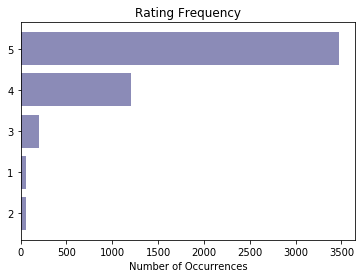

In [0]:
ratings = amazon_reviews_dataset_pd_df['reviews_rating'].value_counts().sort_values(ascending=True ) 
print(amazon_reviews_dataset_pd_df['reviews_rating'].value_counts(normalize=True).sort_values(ascending=False ) )
objects = ratings.keys() 
y_pos = np.arange(len(objects)) 
rating_values = ratings.values 
plt.barh(y_pos, rating_values, align='center', alpha=0.5, color = "midnightblue") 
plt.yticks(y_pos, objects) 
plt.xlabel('Number of Occurrences') 
plt.title('Rating Frequency') 
plt.show()

We will now step into exploring the dataset for initial ideas.

The following code takes two parameters, the Part of SPeech and the text. It returns the top 15 words from the text by frequency.

'top15_frequent_adjectives' function passes adjective as the POS type into the findtags function and prints all the top 15 adjectives along with their frequency of occurance.

In [0]:
# Create functions to return top 15 words by frequency 

def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(15)) for tag in cfd.conditions())

def top15_frequent_adjectives(txt):
  tagdict = findtags('JJ', nltk.pos_tag(txt))
  list_with_words = []
  for tag in sorted(tagdict):
    for othertag in tagdict[tag]:
      list_with_words.append(othertag)
  return(list_with_words)

def wondcloud_func(df):
  d = {}
  for a, x in df:
    d[a] = x
  wordcloud = WordCloud()
  wordcloud.generate_from_frequencies(frequencies=d)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

We apply the above function to all the review levels. This is done to determine the most common positive, negative and neutral adjectives in each review level. This words will be used to create our labelling functions.

For the review level 1 which will be later categorized as negative, the most common adjectives are the following:

Top 15 adjectives for Review Level 1


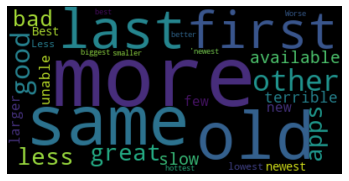

In [0]:
print("Top 15 adjectives for Review Level 1")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level1.select('reviews_text').collect()))
wondcloud_func(top15_frequent_adjectives(txt))

For the review level 2 which will be later categorized as negative, the most common adjectives are the following:

Top 15 adjectives for Review Level 2


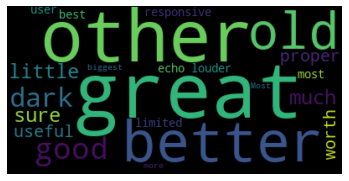

In [0]:
print("Top 15 adjectives for Review Level 2")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level2.select('reviews_text').collect()))
wondcloud_func(top15_frequent_adjectives(txt))


For the review level 3 which will be later categorized as neutral, the most common adjectives are the following:

Top 15 adjectives for Review Level 3


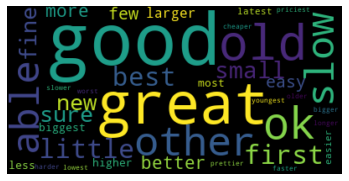

In [0]:
print("Top 15 adjectives for Review Level 3")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level3.select('reviews_text').collect()))
wondcloud_func(top15_frequent_adjectives(txt))

For the review level 4 which will be later categorized as positive, the most common adjectives are the following:

Top 15 adjectives for Review Level 4


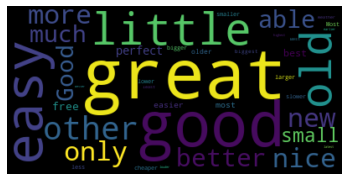

In [0]:
print("Top 15 adjectives for Review Level 4")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level4.select('reviews_text').collect()))
wondcloud_func(top15_frequent_adjectives(txt))

For the review level 5 which will be later categorized as positive, the most common adjectives are the following:

Top 15 adjectives for Review Level 5


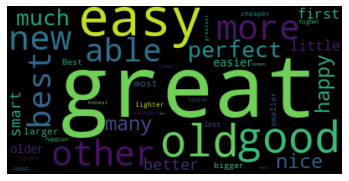

In [0]:
print("Top 15 adjectives for Review Level 5")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level5.select('reviews_text').collect()))
wondcloud_func(top15_frequent_adjectives(txt))

## 5. Writing Labeling Functions (LFs)

We split our data into two subsets:

Training Set: this will contain the largest amount of data points from the dataset; for which we will create labels through weak supervision.

Test Set: this will contain only a standard, small hold-out blind hand-labeled set; which will be used for final evaluation of our classifier.

80% of our reviews are combined to create the train set, while 20% of our reviews are combined to create the test set (Snorkel.org, 2020).

In [0]:
# Train/Test Split - 80/20 
df_train, df_test = amazon_reviews_dataset_rdd.randomSplit([0.8, 0.2], seed=42)

# Code to convert our y_test values into positive/negative and neutral and convert it to series, as input for the 
#accuracy comparision later as the Majority Accuaracy function needs input as numpy. 

Y_test = df_test.toDF()
Y_test = Y_test.toPandas()

Y_test.loc[Y_test['reviews_rating'] == 1, 'reviews_rating'] = 0
Y_test.loc[Y_test['reviews_rating'] == 2, 'reviews_rating'] = 0
Y_test.loc[Y_test['reviews_rating'] == 3, 'reviews_rating'] = 2
Y_test.loc[Y_test['reviews_rating'] == 4, 'reviews_rating'] = 1
Y_test.loc[Y_test['reviews_rating'] == 5, 'reviews_rating'] = 1

Y_test = Y_test['reviews_rating']

The main aim for developing labelling functions is to develop a high quality set of training labels for the Amazon reviews dataset which is unlabelled. The labels for the training set are utilized to train a different discriminative model. This is done in order to generalize to novel, unseen data points. By utilizing this model, we will be able to create certain predictions for the data points that are not covered by our labelling functions (Snorkel.org, 2020).

First, we define constants to represent the class labels for negative, positive and neutral reviews.

We define constants to represent the class labels for: 

- NEGATIVE = 0
- POSITIVE = 1
- NEUTRAL = 2
- ABSTAIN = -1

In [0]:
# Set voting values

NEGATIVE = 0
POSITIVE = 1
NEUTRAL = 2

ABSTAIN = -1

In [0]:
ReviewNEGATIVE =  r"(same|old|bad|slow|terrible|unable|few|worse|less|worse|limited)"

# Top 15 adjectives for Review Level 1
# JJ [('same', 10), ('old', 9), ('last', 9), ('first', 8), ('other', 7), ('good', 6), ('great', 6), ('apps', 6), ('bad', 5), ('available', 5), ('slow', 5), ('terrible', 5), ('unable', 4), ('new', 4), ('few', 4)]
# JJR [('more', 14), ('less', 6), ('larger', 4), ('Less', 2), ('smaller', 1), ('better', 1), ('Worse', 1)]
# JJS [('newest', 3), ('Best', 3), ('lowest', 2), ('biggest', 1), ("'newest", 1), ('hottest', 1), ('best', 1)]
# 63 Rows in DF

# Top 15 adjectives for Review Level 2
# JJ [('great', 5), ('other', 5), ('old', 4), ('good', 4), ('dark', 3), ('little', 3), ('sure', 3), ('much', 3), ('proper', 2), ('useful', 2), ('worth', 2), ('responsive', 2), ('limited', 2), ('user', 2), ('echo', 2)]
# JJR [('better', 5), ('louder', 2), ('more', 1)]
# JJS [('best', 2), ('most', 2), ('biggest', 1), ('Most', 1)]
# 54 Rows in DF

ReviewNEUTRAL = r"(ok|fine)" 

# Top 15 adjectives for Review Level 3
# JJ [('good', 47), ('great', 28), ('old', 19), ('ok', 15), ('other', 13), ('able', 12), ('slow', 12), ('little', 11), ('first', 11), ('small', 10), ('new', 9), ('sure', 9), ('fine', 9), ('few', 8), ('easy', 8)]
# JJR [('better', 9), ('more', 9), ('larger', 5), ('less', 3), ('higher', 3), ('easier', 2), ('older', 1), ('longer', 1), ('slower', 1), ('bigger', 1), ('harder', 1), ('prettier', 1), ('cheaper', 1), ('faster', 1)]
# JJS [('best', 11), ('most', 3), ('biggest', 3), ('latest', 2), ('priciest', 1), ('worst', 1), ('lowest', 1), ('youngest', 1)]
# 197 Rows in DF

ReviewPOSITIVE = r"(great|good|easy|reliable|nice|new|perfect|better|happy)" 

# Top 15 adjectives for Review Level 4
# JJ [('great', 254), ('good', 202), ('easy', 137), ('little', 97), ('old', 90), ('other', 86), ('nice', 60), ('new', 59), ('only', 58), ('able', 46), ('much', 42), ('Good', 42), ('small', 41), ('perfect', 41), ('free', 36)]
# JJR [('more', 61), ('better', 50), ('easier', 20), ('older', 13), ('bigger', 11), ('less', 10), ('cheaper', 9), ('lower', 8), ('larger', 8), ('smaller', 8), ('slower', 7), ('weather', 4), ('earlier', 3), ('louder', 3), ('Better', 3)]
# JJS [('best', 31), ('most', 21), ('Most', 8), ('biggest', 5), ('least', 4), ('Best', 4), ('latest', 3), ('highest', 3), ('smallest', 2), ('lightest', 2), ('guest', 2), ('greatest', 1), ('cheapest', 1), ('lowest', 1), ('brightest', 1)]
# 1208 Rows in DF

# Top 15 adjectives for Review Level 5
# JJ [('great', 804), ('easy', 427), ('old', 292), ('good', 285), ('other', 187), ('new', 179), ('able', 155), ('perfect', 143), ('much', 137), ('nice', 116), ('happy', 114), ('many', 113), ('smart', 101), ('first', 89), ('little', 89)]
# JJR [('more', 188), ('better', 109), ('older', 61), ('easier', 58), ('larger', 33), ('smaller', 27), ('bigger', 25), ('less', 20), ('lighter', 15), ('cheaper', 15), ('lower', 11), ('faster', 11), ('newer', 10), ('happier', 9), ('higher', 8)]
# JJS [('best', 152), ('most', 33), ('Best', 24), ('least', 12), ('latest', 10), ('youngest', 6), ('greatest', 5), ('honest', 5), ('nest', 4), ('Most', 3), ('fastest', 2), ('oldest', 2), ('biggest', 2), ('simplest', 2), ('longest', 2)]
# 3478 Rows in DF

We will now write labelling functions to determine whether positive reviews are contained in the last two rating tiers, negative reviews are contained in the first two rating tiers and neutral reviews are contained in the third tier.

In [0]:
# labelling functions based off specific words
@labeling_function()
def review_NEGATIVE(x):
      return NEGATIVE if re.search(ReviewNEGATIVE, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_NEUTRAL(x):
    return NEUTRAL if re.search(ReviewNEUTRAL, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_POSITIVE(x):
    return POSITIVE if re.search(ReviewPOSITIVE, x.reviews_text.lower()) else ABSTAIN

## 6. Writing More Labeling Functions

The next heuristic that we are looking at is the number of word that the unhappy customers write to understand if there is a significant difference 
between our five rating levels.

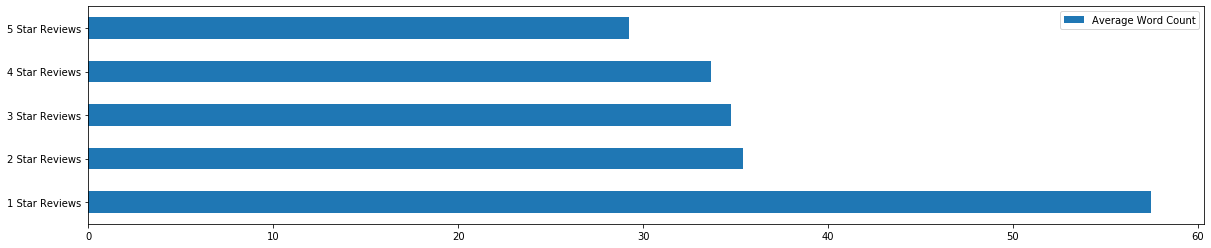

In [0]:
def get_avg_wordcount(DF):
  df = DF.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' ')))
  totalwords = df.groupBy().sum().collect()[0][0]
  colcount = DF.count()
  avgwordcount = totalwords/colcount
  return avgwordcount

pandD = pd.DataFrame(data = [get_avg_wordcount(amazon_reviews_level1),
                             get_avg_wordcount(amazon_reviews_level2),
                             get_avg_wordcount(amazon_reviews_level3),
                             get_avg_wordcount(amazon_reviews_level4),
                             get_avg_wordcount(amazon_reviews_level5)], columns=['Average Word Count'], index=['1 Star Reviews',
                                                                                                              '2 Star Reviews',
                                                                                                              '3 Star Reviews',
                                                                                                              '4 Star Reviews',
                                                                                                              '5 Star Reviews'])
                             
pandD.plot.barh(figsize=(20,4))

(0, 125)

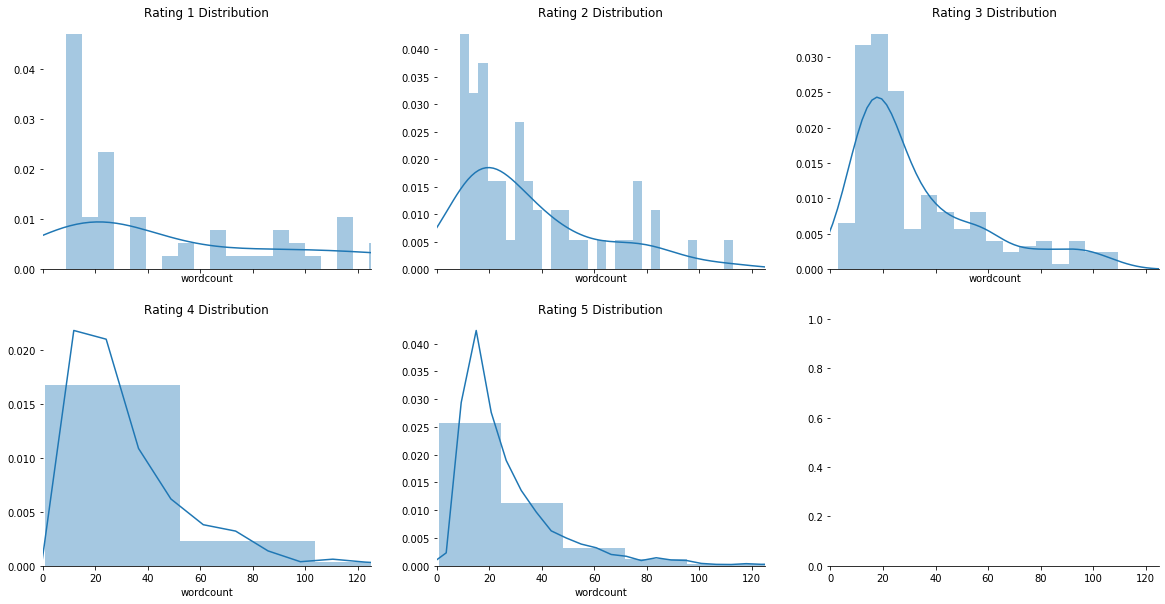

In [0]:
am_rev_wordcount1= amazon_reviews_level1.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()
am_rev_wordcount2= amazon_reviews_level2.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()
am_rev_wordcount3= amazon_reviews_level3.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()
am_rev_wordcount4= amazon_reviews_level4.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()
am_rev_wordcount5= amazon_reviews_level5.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()

figuresssss, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(am_rev_wordcount1['wordcount'], bins=30, kde=True, ax=axes[0, 0])
sns.distplot(am_rev_wordcount2['wordcount'], bins=30, kde=True, ax=axes[0, 1])
sns.distplot(am_rev_wordcount3['wordcount'], bins=30, kde=True, ax=axes[0, 2])
sns.distplot(am_rev_wordcount4['wordcount'], bins=30, kde=True, ax=axes[1, 0])
sns.distplot(am_rev_wordcount5['wordcount'], bins=30, kde=True, ax=axes[1, 1])
axes[0, 0].set_title("Rating 1 Distribution")
axes[0, 1].set_title("Rating 2 Distribution")
axes[0, 2].set_title("Rating 3 Distribution")
axes[1, 0].set_title("Rating 4 Distribution")
axes[1, 1].set_title("Rating 5 Distribution")
plt.xlim(0, 125)

The clearest trend is that very unhappy customrs tend to write longer reviews than  happier customers. On the other side, by looking at their frequency of the reviews length, their values seem to overlap. This means that we could infer the difference between positive and negative by simply seeing very long or very short reviews, however not the overlapping values.

In [0]:
@labeling_function()
def pos_string_length(x):
  return POSITIVE if len(x.reviews_text.split()) <= 30 else ABSTAIN

In [0]:
@labeling_function()
def neg_string_length(x):
  return NEGATIVE if len(x.reviews_text.split()) >= 40 else ABSTAIN

We will now move forward with out analysis and start writting a labelling function that uses a third-party model. For this, we will use the TextBlob tool which supplies a pretrained sentiment analyzer(Snorkel.org, 2020).

First, we develope a function that runs TextBlob on our review comments and obtains the polarity scores.

In [0]:
def getSentiment(text):
    x = {}
    x["polarity"] = TextBlob(text).sentiment.polarity
    x["subjectivity"] = TextBlob(text).sentiment.subjectivity 
    return x

Then, we create a labelling function to identify if:

- positive reviews have a polarity score of 0.2 or above;
- neutral reviews have a polarity score of -0.2 or above;
- negative reviews have a polarity score of less than 0.2.

In [0]:
@labeling_function()
def textblob_polarity(x):
    x = getSentiment(x.reviews_text)

    if x["polarity"] >= 0.2:
      return POSITIVE 
    if x["polarity"] >= -0.2:
      return NEUTRAL
    if x["polarity"] < -0.2:
      return NEGATIVE
    else:
      return ABSTAIN

## 7. Labelling, Analysis and Accuracy

We must now use the LabelModel to programatically learn to combine our labelling functions' outputs into strong probabilist labels (Snorkel.org, 2020).

After analysis of different combinations of the previously created labelling functions, we kept the combination of labelling functions that in the end gave us the best accuracy score.

In [0]:
# Kept the the combination of lablling functions that give us the best accuracy score
labelingfunctions = [review_NEUTRAL, review_POSITIVE, textblob_polarity, pos_string_length]

To apply the combination of labelling functions to the collection of data points, we need to use an LFApplier. In this case, we used the SparkLFApplier because our data points are represented with a RDD.

In [0]:
applier = SparkLFApplier(lfs=labelingfunctions)

L_train = applier.apply(data_points=df_train)
L_test = applier.apply(data_points=df_test)

Snorkel provides tooling for common LF analyses using the LFAnalysis utility. Thus, we were able to report the following summary statistics for multiple LFs at once:

- Polarity: The set of unique labels this labelling function outputs
- Coverage: The percentage of the dataset the labelling function labels
- Overlaps: The percentage of the dataset where this labelling functions and at least one other labelling functions label
- Conflicts: The percentage of the dataset where this labelling function and at least one other labelling function label and disagree (Snorkel.org, 2020).

Basically, these scores helped us decide which combination of labeling functions to keep in order to get a higher accuracy score.

In [0]:
LFAnalysis(L=L_train, lfs=labelingfunctions).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
review_NEGATIVE,0,[0],0.176574,0.176574,0.175571
review_NEUTRAL,1,[2],0.164535,0.164535,0.156759
review_POSITIVE,2,[1],0.603210,0.603210,0.223476
textblob_polarity,3,"[0, 1, 2]",1.000000,0.947580,0.419363
pos_string_length,4,[1],0.697015,0.697015,0.252571


Now, our aim is to adapt the labels into a single probabilist label per data point. The majority voting per data point will be used as a baseline.

In [0]:
majority_model = MajorityLabelVoter(cardinality=5)
preds_train = majority_model.predict(L=L_train)

The following LabelModel combines the outputs of the labelling functions. This single set of labels will be used to train a classifier.

In [0]:
label_model = LabelModel(cardinality=5, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [0]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   80.8%
Label Model Accuracy:     66.1%


The following histogram shows the confidence level our model that has that each data point has the right label - positive/negative/neutral. The most uncertain ponts will have their labels to 0.5.

In [0]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("TBC")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
# plot_probabilities_histogram(probs_train[:, POSITIVE])
# plot_probabilities_histogram(probs_train[:, NEGATIVE])
# plot_probabilities_histogram(probs_train[:, NEUTRAL])

Then, we must convert the DataFrame to Pandas to get the following code working and to prepare for training the classifier.

In [0]:
# Convert the df_train to Pandas to get the code below working and to prep for training the model

df_train = df_train.toDF()
df_train = df_train.toPandas()

df_test = df_test.toDF()
df_test = df_test.toPandas()

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(X=df_train, y=probs_train, L=L_train)

*`italicized text`*## 8. Training a Classifier

Finally, we are to train a classfier to obtain the accuracy score of the combination of models.

In [0]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils
# print(df_train)

Through the probs_to_preds method, We can change each label distribution with the label of the class that has the maximum level of probability (Snorkel.org, 2020).

In [0]:
# use a simple “bag of n-grams” feature representation
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.reviews_text.tolist())
X_test = vectorizer.transform(df_test.reviews_text.tolist())

In [0]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

Then we can easily use these labels to train a classifier.

In [0]:
from sklearn.naive_bayes import MultinomialNB
sklearn_model = MultinomialNB()
sklearn_model.fit(X=X_train, y=preds_train_filtered)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 86.4%


We observe an increase in the accuracy score compared to the above LabelModel. That is because:

- the discriminative model generalizes beyond the labels of the labeling functions;
- creates accurate predictions on all data points( while the LabelModel creates accurate predictions on only the data points covered by labeling functions).

We are to utilize a label model to pass the domain knowledge encoded in our labelling functions to the discriminative model so that we would be able to generalize beyond the noisy labelling heuristics(Snorkel.org, 2020).

**bold text**#

```
# This is formatted as code
```

## 9. Summary and Conclusion

Firstly, we installed the necessary libraries and loaded the dataset.

Secondly, we explored the dataset to get some initial ideas.

Thirdly, we decided that our main goal is to determine whether positive reviews are contained in the last 2 rating tiers, negative reviews are contained in the first two rating tiers and neutral reviews are contained in the third rating tier. As such based on this, we created our main labelling functions.

Fourthly, we created more labelling functions that would help with our later analysis. A such we we created heuristic labelling functions to determine if positive reviews have generally less words and if negative reviews have generally more words.Then, we created a labelling function to identify whether positive reviews have a high polarity score, neutral reviews have an average polarity score and negative reviews have a low polarity score.

Fifthly, we used the LabelModel to programatically learn to combine our labelling functions' outputs into strong probabilist labels. After analysis of different combinations of labelling functions we kept the combination that that would give us the highest accuracy score.

Finally, we trained a classifier to test our model's accuracy score on the test set. We showes that a classifier trained with weak supervision can exceed a method based on only labelling functions as it's able to generalize beyond the noisy labelling heuristics(Snorkel.org, 2020).

italicized text## 10. References

Snorkel.org. (2020). Snorkel Intro Tutorial: Data Labeling. [online] Available at: https://www.snorkel.org/use-cases/01-spam-tutorial [Accessed 6 Mar. 2020].

** ADD REFERENCE FOR THE AMAZON DATASET **

https://www.snorkel.org/use-cases/01-spam-tutorial

https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb

https://adataanalyst.com/spark/building-word-count-application-spark/

https://spark.apache.org/docs/2.2.0/mllib-naive-bayes.html

https://snorkel.readthedocs.io/en/v0.9.3/packages/labeling.html

https://textblob.readthedocs.io/en/dev/classifiers.html#classifying-text

https://www.nltk.org/_modules/nltk/sentiment/vader.html

https://towardsdatascience.com/natural-language-processing-in-apache-spark-using-nltk-part-2-2-5550b85f3340


https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

Stackoverflow:
https://stackoverflow.com/questions/38465478/wordcloud-from-data-frame-with-frequency-python
